In [1]:

!pip install torch torchvision torchaudio pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
from google.colab import files
uploaded = files.upload()


In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Compute mean and std from train set to normalize mel spectrograms
def compute_mel_stats(csv_path):
    df = pd.read_csv(csv_path)
    mel_stack = []
    for mel_str in df["mel_flat"]:
        mel = np.array([float(x) for x in mel_str.strip().split()], dtype=np.float32).reshape(80, 50)
        mel_stack.append(mel)
    mel_stack = np.stack(mel_stack)
    mean = mel_stack.mean(axis=(0, 2), keepdims=True)  # shape (80, 1)
    std = mel_stack.std(axis=(0, 2), keepdims=True)
    return mean, std

mean, std = compute_mel_stats("/content/mel_train.csv")

class MelDataset(Dataset):
    def __init__(self, csv_path, mean, std):
        df = pd.read_csv(csv_path)
        self.mels = []
        self.speaker_ids = []
        for _, row in df.iterrows():
            mel = np.array([float(x) for x in row["mel_flat"].split()], dtype=np.float32).reshape(80, 50)
            mel = (mel - mean) / std
            self.mels.append(torch.tensor(mel))
            self.speaker_ids.append(int(row["speaker_id"]))
        self.mels = torch.stack(self.mels)
        self.speaker_ids = torch.tensor(self.speaker_ids)

    def __len__(self):
        return len(self.mels)

    def __getitem__(self, idx):
        return self.mels[idx], self.speaker_ids[idx]


In [5]:
import torch.nn as nn

class SpeakerEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, embed_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        return self.encoder(x)

class MelDecoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 80 * 50)
        )

    def forward(self, speaker_embed):
        x = self.decoder(speaker_embed)
        return x.view(-1, 80, 50)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [13]:
class MelDataset(Dataset):
    def __init__(self, csv_path, mean=None, std=None):
        df = pd.read_csv(csv_path)
        self.mels = []
        self.labels = []
        for _, row in df.iterrows():
            mel = np.array([float(x) for x in row["mel_flat"].split()], dtype=np.float32).reshape(80, 50)
            self.mels.append(mel)
            self.labels.append(row["speaker_id"])
        self.mels = np.stack(self.mels)

        if mean is None:
            self.mean = self.mels.mean(axis=(0, 2), keepdims=True)  # (80, 1)
            self.std = self.mels.std(axis=(0, 2), keepdims=True) + 1e-6
        else:
            self.mean = mean
            self.std = std
        self.mels = (self.mels - self.mean) / self.std

    def __len__(self):
        return len(self.mels)

    def __getitem__(self, idx):
        return torch.tensor(self.mels[idx]), torch.tensor(self.labels[idx])


In [14]:
class SpeakerEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((10, 6)),
            nn.Flatten(),
            nn.Linear(64 * 10 * 6, embed_dim)
        )

    def forward(self, mel):
        x = mel.unsqueeze(1)  # (B, 1, 80, 50)
        return self.net(x)

class MelDecoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 80 * 50)
        )

    def forward(self, embed):
        x = self.net(embed)
        return x.view(-1, 80, 50)


In [15]:
train_dataset = MelDataset("/content/mel_train.csv")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = MelDataset("/content/mel_val.csv", mean=train_dataset.mean, std=train_dataset.std)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SpeakerEncoder().to(device)
decoder = MelDecoder().to(device)


In [21]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0

    for mel, _ in train_loader:
        mel = mel.to(device)

        optimizer.zero_grad()
        embed = encoder(mel)
        recon = decoder(embed)

        mse_loss = F.mse_loss(recon, mel)
        cos_loss = 1 - F.cosine_similarity(recon.view(recon.size(0), -1), mel.view(mel.size(0), -1)).mean()
        loss = mse_loss + 0.1 * cos_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/200, Loss: 1.0894
Epoch 2/200, Loss: 1.0858
Epoch 3/200, Loss: 1.0847
Epoch 4/200, Loss: 1.0835
Epoch 5/200, Loss: 1.0832
Epoch 6/200, Loss: 1.0823
Epoch 7/200, Loss: 1.0817
Epoch 8/200, Loss: 1.0814
Epoch 9/200, Loss: 1.0818
Epoch 10/200, Loss: 1.0805
Epoch 11/200, Loss: 1.0795
Epoch 12/200, Loss: 1.0785
Epoch 13/200, Loss: 1.0784
Epoch 14/200, Loss: 1.0761
Epoch 15/200, Loss: 1.0756
Epoch 16/200, Loss: 1.0737
Epoch 17/200, Loss: 1.0749
Epoch 18/200, Loss: 1.0844
Epoch 19/200, Loss: 1.0777
Epoch 20/200, Loss: 1.0776
Epoch 21/200, Loss: 1.0764
Epoch 22/200, Loss: 1.0729
Epoch 23/200, Loss: 1.0719
Epoch 24/200, Loss: 1.0679
Epoch 25/200, Loss: 1.0725
Epoch 26/200, Loss: 1.0708
Epoch 27/200, Loss: 1.0708
Epoch 28/200, Loss: 1.0720
Epoch 29/200, Loss: 1.0725
Epoch 30/200, Loss: 1.0705
Epoch 31/200, Loss: 1.0698
Epoch 32/200, Loss: 1.0678
Epoch 33/200, Loss: 1.0662
Epoch 34/200, Loss: 1.0654
Epoch 35/200, Loss: 1.0656
Epoch 36/200, Loss: 1.0680
Epoch 37/200, Loss: 1.0673
Epoch 38/2

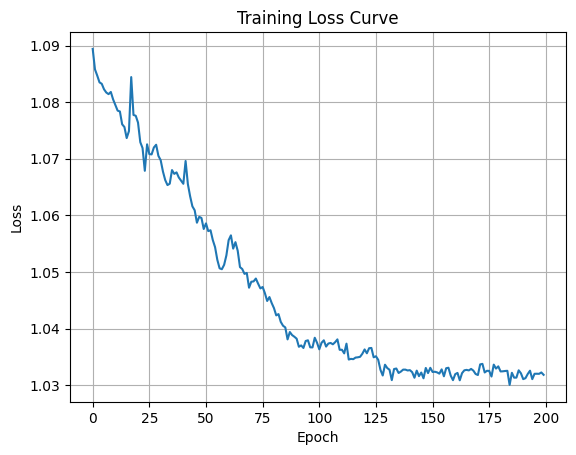

In [22]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [23]:
encoder.eval()
decoder.eval()

ref_df = pd.read_csv("/content/mel_reference.csv")
results = []

for _, row in ref_df.iterrows():
    speaker_id = int(row["speaker_id"])
    mel = np.array([float(x) for x in row["mel_flat"].split()], dtype=np.float32).reshape(80, 50)

    mel = (mel - train_dataset.mean.reshape(80, 1)) / train_dataset.std.reshape(80, 1)
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)

    with torch.no_grad():
        embed = encoder(mel_tensor)
        predicted_mel = decoder(embed).squeeze().cpu().numpy().flatten()

    results.append({
        "speaker_id": speaker_id,
        "predicted_mel_flat": " ".join([f"{x:.6f}" for x in predicted_mel])
    })

pred_df = pd.DataFrame(results)
pred_df.to_csv("cloned_mel_predictions.csv", index=False)

from google.colab import files
files.download("cloned_mel_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

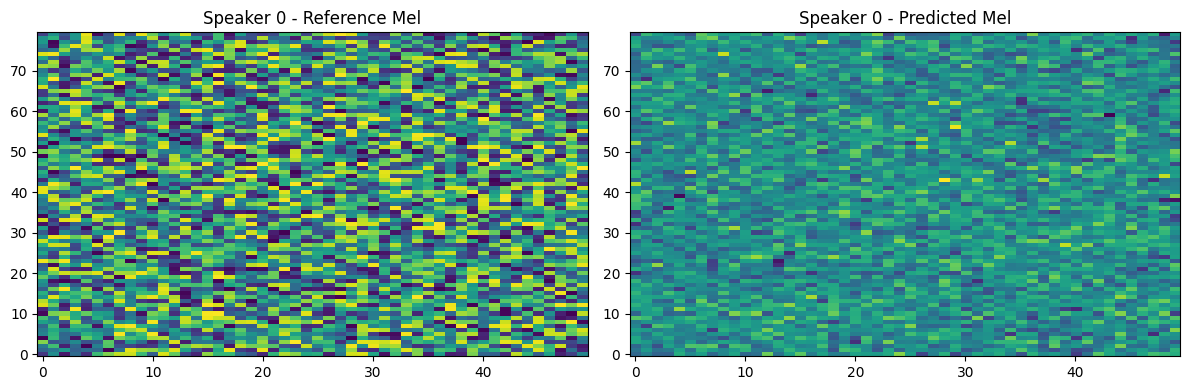

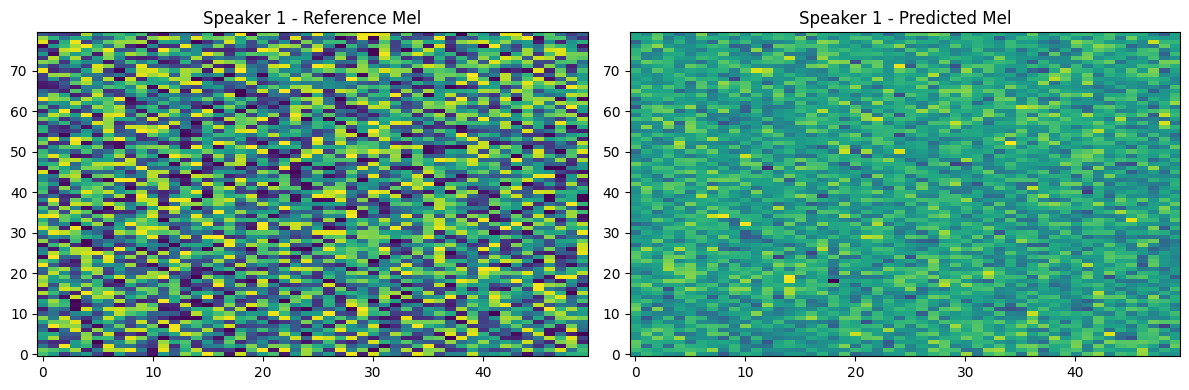

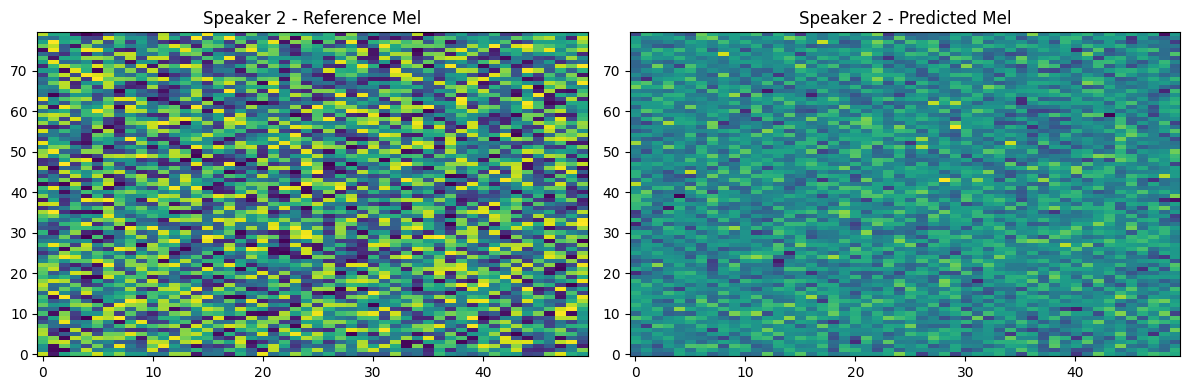

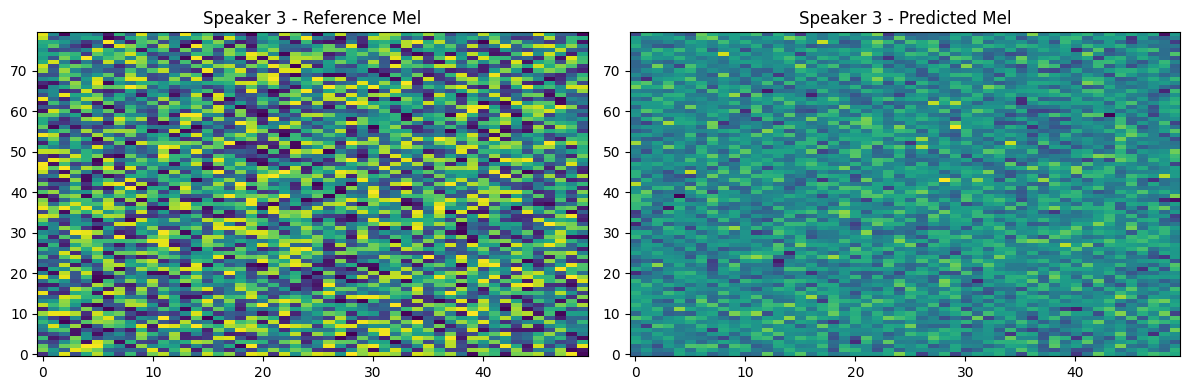

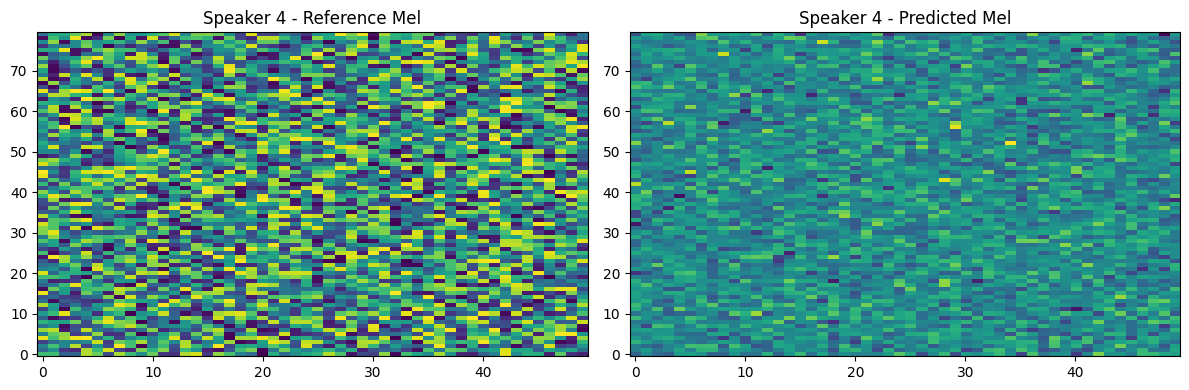

In [24]:
import matplotlib.pyplot as plt

ref_df = pd.read_csv("/content/mel_reference.csv")
pred_df = pd.read_csv("/content/cloned_mel_predictions (1).csv")

def plot_mel_spectrograms(ref_mel, pred_mel, speaker_id):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(ref_mel, aspect='auto', origin='lower')
    axs[0].set_title(f"Speaker {speaker_id} - Reference Mel")
    axs[1].imshow(pred_mel, aspect='auto', origin='lower')
    axs[1].set_title(f"Speaker {speaker_id} - Predicted Mel")
    plt.tight_layout()
    plt.show()

for i in range(len(ref_df)):
    speaker_id = ref_df.loc[i, "speaker_id"]
    ref_mel = np.array([float(x) for x in ref_df.loc[i, "mel_flat"].split()]).reshape(80, 50)
    pred_mel = np.array([float(x) for x in pred_df.loc[i, "predicted_mel_flat"].split()]).reshape(80, 50)
    plot_mel_spectrograms(ref_mel, pred_mel, speaker_id)


In [25]:
## using Tacotron Decoder


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class MelDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.data = []
        for _, row in df.iterrows():
            mel = np.array([float(x) for x in row["mel_flat"].split()], dtype=np.float32).reshape(80, 50)
            self.data.append(mel)
        self.data = np.stack(self.data)
        self.mean = np.mean(self.data, axis=(0, 2), keepdims=True)
        self.std = np.std(self.data, axis=(0, 2), keepdims=True)
        self.data = (self.data - self.mean) / self.std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), 0

class SpeakerEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((10, 6)),
            nn.Flatten(),
            nn.Linear(64 * 10 * 6, embed_dim)
        )

    def forward(self, mel):
        x = mel.unsqueeze(1)
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_outputs, decoder_hidden):
        att1 = self.encoder_att(encoder_outputs)                     # (B, T, attn)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)        # (B, 1, attn)
        energy = self.full_att(torch.tanh(att1 + att2)).squeeze(-1) # (B, T)
        alpha = F.softmax(energy, dim=1)                             # (B, T)
        context = (encoder_outputs * alpha.unsqueeze(-1)).sum(dim=1)
        return context, alpha

class TacotronDecoder(nn.Module):
    def __init__(self, encoder_dim=128, attention_dim=64, decoder_dim=256, mel_dim=80, time_steps=50):
        super().__init__()
        self.time_steps = time_steps
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.rnn = nn.GRUCell(mel_dim + encoder_dim, decoder_dim)
        self.linear = nn.Linear(decoder_dim, mel_dim)

    def forward(self, encoder_outputs):
        B = encoder_outputs.size(0)
        decoder_hidden = torch.zeros(B, 256, device=encoder_outputs.device)
        prev_output = torch.zeros(B, 80, device=encoder_outputs.device)
        outputs = []

        for _ in range(self.time_steps):
            context, _ = self.attention(encoder_outputs, decoder_hidden)
            rnn_input = torch.cat([prev_output, context], dim=-1)
            decoder_hidden = self.rnn(rnn_input, decoder_hidden)
            output = self.linear(decoder_hidden)
            outputs.append(output.unsqueeze(2))
            prev_output = output

        return torch.cat(outputs, dim=2)  # (B, 80, 50)



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MelDataset("/content/mel_train.csv")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

encoder = SpeakerEncoder().to(device)
decoder = TacotronDecoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

loss_curve = []
for epoch in range(1, 31):
    encoder.train()
    decoder.train()
    total_loss = 0

    for mel, _ in train_loader:
        mel = mel.to(device)
        optimizer.zero_grad()
        embed = encoder(mel)
        encoder_outputs = embed.unsqueeze(1).repeat(1, 10, 1)
        pred = decoder(encoder_outputs)
        mse = F.mse_loss(pred, mel)
        cos = 1 - F.cosine_similarity(pred.view(pred.size(0), -1), mel.view(mel.size(0), -1)).mean()
        loss = mse + 0.1 * cos
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_curve.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 1.1249
Epoch 2, Loss: 1.1064
Epoch 3, Loss: 1.1043
Epoch 4, Loss: 1.1017
Epoch 5, Loss: 1.0992
Epoch 6, Loss: 1.0974
Epoch 7, Loss: 1.0938
Epoch 8, Loss: 1.0919
Epoch 9, Loss: 1.0907
Epoch 10, Loss: 1.0881
Epoch 11, Loss: 1.0869
Epoch 12, Loss: 1.0855
Epoch 13, Loss: 1.0841
Epoch 14, Loss: 1.0833
Epoch 15, Loss: 1.0815
Epoch 16, Loss: 1.0801
Epoch 17, Loss: 1.0787
Epoch 18, Loss: 1.0775
Epoch 19, Loss: 1.0762
Epoch 20, Loss: 1.0748
Epoch 21, Loss: 1.0737
Epoch 22, Loss: 1.0725
Epoch 23, Loss: 1.0714
Epoch 24, Loss: 1.0705
Epoch 25, Loss: 1.0694
Epoch 26, Loss: 1.0684
Epoch 27, Loss: 1.0672
Epoch 28, Loss: 1.0659
Epoch 29, Loss: 1.0652
Epoch 30, Loss: 1.0642


In [28]:
import pandas as pd
import numpy as np
import torch

ref_df = pd.read_csv("/content/mel_reference.csv")
results = []

mean = train_dataset.mean
std = train_dataset.std


In [31]:
encoder.eval()
decoder.eval()

results = []

mean = train_dataset.mean.squeeze().reshape(80, 1)
std = train_dataset.std.squeeze().reshape(80, 1)

for _, row in ref_df.iterrows():
    speaker_id = int(row["speaker_id"])

    mel = np.array([float(x) for x in row["mel_flat"].split()], dtype=np.float32).reshape(80, 50)
    mel = (mel - mean) / std

    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # (1, 80, 50)

    with torch.no_grad():
        embed = encoder(mel_tensor)
        encoder_outputs = embed.unsqueeze(1).repeat(1, 10, 1)
        predicted_mel = decoder(encoder_outputs).squeeze().cpu().numpy().flatten()

    results.append({
        "speaker_id": speaker_id,
        "predicted_mel_flat": " ".join([f"{x:.6f}" for x in predicted_mel])
    })

pred_df = pd.DataFrame(results)
pred_df.to_csv("cloned_mel_predictions_tacotron.csv", index=False)

from google.colab import files
files.download("cloned_mel_predictions_tacotron.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>